# EMアルゴリズム

最尤推定またはMAP推定を数値的に行う手法。これらが解析的に行えない場合に活躍する。

参考
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)
- [EMアルゴリズム徹底解説 - Qiita](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818)

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import random


---

## 潜在変数

データ$x$の裏に潜む、$x$をよく表した**観測できない**変数。

EMアルゴリズムでは、観測されたデータ$X=(x_1, x_2, \cdots, x_n)$に対して潜在変数$Z=(z_1, z_2, \cdots, z_n)$を導入する。$x$に影響を与える潜在変数$z$を考え、それがどのように$x$に作用するかをモデル化するということ。なお多くの場合、潜在変数にはサンプリングが容易な確率分布が仮定できる必要がある。EMアルゴリズムも該当する。

分布が複雑な時は、潜在変数を導入することで計算が簡単になる場合が多い。

<br>

潜在変数の導入を数学的に表現すると、それは同時分布を定めることとなる。

$$
p(x, z) = p(x|z)p(z)
$$

潜在変数の分布$p(z)$と、それがデータ$x$にどう作用するかを表す条件付き分布$p(x|z)$を定めている。


---

## 理論

計算方法を見ていく。

まず対数尤度関数を考える。

$$
\begin{align}
    \log L(\theta|X)
        &= \log \prod_{i=1}^n p(x_i;\theta) \\
        &= \sum_{i=1}^n \log p(x_i;\theta) \\
\end{align}
$$

尤度$p(x_i;\theta)$が複雑で、このまま進めても解が求められない場合を考えていく。

ここで潜在変数を導入する。

$$
\begin{align}
p(x;\theta)
    &= \sum_{j=1}^k p(x,z_j;\theta) \\
    &= \sum_{z=1}^k (p(x|z_j;\theta) p(z_j))
\end{align}
$$

$k$種類の離散的な潜在変数を仮定した。$p(x|z_j;\theta)$は潜在変数$z_j$の下での$x$の分布で、$p(z_k)$は潜在変数$z_k$の分布。先で述べた通り、この二つの分布を具体的に定義することが前提となる。

では対数尤度を見ていく。

$$
\begin{align}
\log p(X;\theta)
    &= \log \sum_Z p(X,Z;\theta) \\
    &= \log \sum_Z q(Z) \frac{p(X,Z;\theta)}{q(Z)} \\
    &\ge \sum_Z q(Z) \log \frac{p(X,Z;\theta)}{q(Z)} \\
    &= \mathcal{L}(q(Z),\theta)
\end{align}
$$

途中の不等式は**イェンゼンの不等式**というもの。  
$q(Z)$はイェンゼンの不等式を使うために適当に持ち出した確率分布。

ここで、対数尤度関数と下界の差を求めると

$$
\log p(X;\theta) - \mathcal{L}(q(Z)|\theta) = \mathrm{KL}[q(Z)||p(Z|X;\theta)]
$$

$q(Z)$と$p(Z|X,\theta)$のKLダイバージェンスになる。途中式は省略。これを以下のようにまとめる。

$$
\log p(X;\theta) = \mathrm{KL}[q(Z)||p(Z|X;\theta)] + \mathcal{L}(q(Z)|\theta)
$$

対数尤度関数をKLダイバージェンスと下界の和で表すことが出来た。これを最大化することを考える。

まずKLダイバージェンスを0にすることを考える。そうすれば対数尤度関数が下界と一致するので、下界の最大化を考えれば良くなる。  
KLダイバージェンスは、二つの確率分布が完全に一致する場合にのみ0をとる。ということで、さっき適当に持ち出した$q(Z)$を$p(Z|X;\theta)$に置き換えればいい。ここの$\theta$は適当に初期化した$\theta_{old}$を使う。

$$
\mathcal{L}(p(Z|X;\theta_{old}),\theta)
$$

これを最大化する$\theta$を求める。で、$\theta_{old}:=\theta_{new}$と更新した上で同じことを繰り返す。こうすることで$\theta$が最適な値に収束する。

では$\mathcal{L}(p(Z|X;\theta_{old}),\theta)$を最大にする$\theta$を求める。  

$$
\begin{align}
    \mathcal{L}(p(Z|X;\theta_{old})|\theta)
        &= \sum_Z p(Z|X;\theta_{old}) \log \frac{p(X,Z;\theta)}{p(Z|X;\theta_{old})} \\
        &= \sum_Z p(Z|X;\theta_{old}) \log p(X,Z;\theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

$z$の事後分布の対数尤度に関する期待値になった。この期待値を求める過程を**Eステップ**と呼ぶ（期待値=*Expected Value*）。

次に、新たな$\theta$として、この下界を最大にする$\theta$を求める。

$$
\begin{align}
    \theta_{new}
        &= \argmax_{\theta} \mathcal{L}(p(Z|X;\theta_{old})|\theta) \\
        &= \argmax_{\theta} \mathcal{Q}(\theta|\theta_{old}) \\
        &= \argmax_{\theta} \sum_Z p(Z|X;\theta_{old}) \log p(X,Z;\theta)
\end{align}
$$

これは偏微分とかで求める。

<br>

この下界を最大化する過程を**Mステップ**と呼ぶ（最大化=*Maximum*）。

EステップとMステップを繰り返すことから、EMアルゴリズムと呼ばれる。


---

## 混合ガウス分布

混合ガウス分布のパラメータを推定しよう．この分布は，複数のガウス分布が混ざった分布．  
混合ガウス分布はEMアルゴリズムに必要な潜在変数を定義しやすく，EMアルゴリズムを適用しやすい．

### 簡単な混合ガウス分布

こんな分布を考える

$$
z \sim \mathrm{Bernoulli}(\theta) \\
x \sim
\begin{cases}
    \mathcal{N}(0, 1) & z = 0 \\
    \mathcal{N}(5, 1) & z = 1
\end{cases}
$$

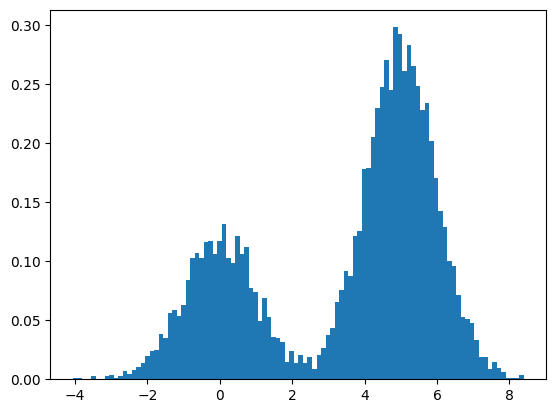

In [ ]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

こんな感じの，二つの正規分布$[\mathcal{N}(0, 1), \mathcal{N}(5, 1)]$が混ざった分布．パラメータは二つの分布の比率（$\mathcal{N}(5, 1)$の割合）を表す$\theta$のみで，↑の例だと$\theta=0.7$が正解．

では，得られたデータから適切な$\theta$を推定をしていこう．

まず潜在変数を考える．今回の例だと，潜在変数として「どちらの分布から得られたか」を表す変数が仮定できそう．そしてこの潜在変数はパラメータ$\theta$のベルヌーイ分布に従いそう．  
ということで，これらの仮定を元に進めていく．（↑の式やコードを見ると，これらの仮定が全て正しいことが確認できる．）



$$

$$

### 一般的な混合ガウス分布

こんな分布を考える

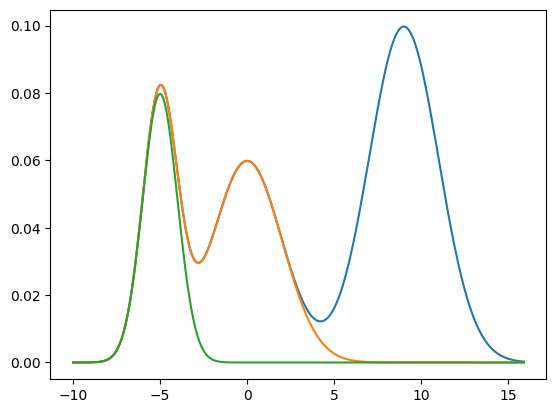

In [ ]:
pi = [0.2, 0.3, 0.5]
mu = [-5., 0., 9.]
sigma = [1., 2., 2.]

norm = [dist.Normal(m, s) for m, s in zip(mu, sigma)]

ax = torch.arange(-10, 16, 0.1)
y = torch.stack([p * n.log_prob(ax).exp() for n, p in zip(norm, pi)])
for i in range(1, 3):
    y[i] += y[i-1]
plt.plot(ax, y.T.flip(-1));

これが3つのガウス分布を足して作られた真の分布